# How to measure a causal effect with observational data

In this notebook we are going to use a simulated dataset to measure study the procedure to measure a causal effect with panel data.

Here is the general procedure:

1 - DAG: The starting point of a causal inference model is the DAG. So revise it if needed.

2 - EDA: Select a perfectly balanced sample including all your variables (outcome, explanatory, heterogeneity, and controls) and do the EDA. (Think about nonlinear effects, lags, and asymmetries)

3 - SLR: Run a Simple Linear Regression

4.a - MLR: Run a Multiple Linear Regression (SLR with the controls)

4.b - DML: Use a Double Machine Learning Model if we have numerous controls and suspect non-linear or interactions effects.

5.a - TWFE: If you still have some unobserved confounders that can be captured by fixed effects, run a fixed effect regression.
5.b - DML FD: If you used previously DML you can use the FD estimator with your DML model.

6.a - Quasi experimental methods if there are still idiosyncratic time varying unobserved confounders.
6.b - DML DiD or DML IV: Some quasi experimental methods can be used as well with DML.

## Model Specifications
In order to test the incremental benefit of each of these steps, we are going to use a simulated dataset.

The Data Generating Process (DGP) will be relatively complex is order to illustrate the role of each of those tools.

### Variables

- **Explanatory Variable** $ X $: A continuous variable generated as a function of observed confounders, an instrumental variable, unobserved confounders, individual fixed effects, and interaction terms. It has a direct effect on the outcome variable $ Y $.
  
- **Confounders**:
  - **Confounder 1** $ C1 $: A continuous variable with a linear effect, normally distributed with mean 0 and standard deviation 1.
  - **Confounder 2** $ C2 $: A continuous variable with a linear effect, normally distributed with mean 0 and standard deviation 1.
  - **Confounder 3** $ C3 $: A continuous variable with both a linear and quadratic effect, normally distributed with mean 0 and standard deviation 1.
  - **Confounder 4** $ C4 $: A continuous variable with a strong linear effect, normally distributed with mean 0 and standard deviation 1.
  
- **Instrumental Variable** $ IV $: A variable generated independently, which influences $ X $ but does not have a direct effect on $ Y $.

- **Unobserved Confounder** $ U $: A time-varying, normally distributed variable with mean 0 and standard deviation 1, affecting both $ X $ and $ Y $.

- **Unobserved Fixed Effect** $ FE $: A time-invariant individual-specific effect, normally distributed with mean 0 and standard deviation 1, which influences both $ X $ and $ Y $.

### Explanatory Variable $ X $

The explanatory variable $ X $ is defined as:

$$
X_{it} = \gamma_{C1} \cdot C1_{it} + \gamma_{C2} \cdot C2_{it} + \gamma_{C3} \cdot C3_{it} + \gamma_{C4} \cdot C4_{it} + \gamma_{IV} \cdot IV_{it} + \gamma_U \cdot U_{it} + \gamma_{C1C2} \cdot (C1_{it} \times C2_{it}) + \gamma_{C3^2} \cdot C3_{it}^2 + \gamma_{FE} \cdot FE_i + \eta_{it}
$$

where:
- $ X_{it} $: Explanatory variable for individual $ i $ at time $ t $
- $ \eta_{it} $: Random noise term, normally distributed with mean 0 and standard deviation 1

### Outcome Variable $ Y $

The outcome variable $ Y $ is defined as a function of the explanatory variable, confounders, interaction effects, and unobserved effects:

$$
Y_{it} = \beta_X \cdot X_{it} + \beta_{C1} \cdot C1_{it} + \beta_{C2} \cdot C2_{it} + \beta_{C3} \cdot C3_{it} + \beta_{C4} \cdot C4_{it} + \beta_U \cdot U_{it} + \beta_{C1C2} \cdot (C1_{it} \times C2_{it}) + \beta_{C3^2} \cdot C3_{it}^2 + \beta_{FE} \cdot FE_i + \epsilon_{it}
$$

where:
- $ Y_{it} $: Outcome variable for individual $ i $ at time $ t $
- $ \epsilon_{it} $: Random noise term, normally distributed with mean 0 and standard deviation 1

### Coefficients
Note that, in order to show the potential benefit of Multiple Linear Regression I included a linear confounder (C4) with a relatively strong effect. If you exclude this confounder, the Multiple Linear Regression which includes all the observed confounders (C1-C4) is doing worse than the Simple Linear Regression due to the misspecification.

I also included a larger coefficient for the unobserved time invarient confounder as it helps to illustrate the benefit from using the First Difference estimator.

Notice, that different specification of this complex DGP would yield different results.

#### For the Explanatory Variable $ X $:
- $ \gamma_{C1} = 1 $: Effect of Confounder 1 on $ X $
- $ \gamma_{C2} = 1 $: Effect of Confounder 2 on $ X $
- $ \gamma_{C3} = 1 $: Linear effect of $ C3 $ on $ X $
- $ \gamma_{C4} = 5 $: Effect of Confounder 4 on $ X $
- $ \gamma_{IV} = 1 $: Effect of Instrumental Variable $ IV $ on $ X $
- $ \gamma_U = 1 $: Effect of Unobserved Confounder $ U $ on $ X $
- $ \gamma_{C1C2} = 1 $: Interaction effect between $ C1 $ and $ C2 $ on $ X $
- $ \gamma_{C3^2} = 1 $: Quadratic effect of $ C3 $ on $ X $
- $ \gamma_{FE} = 5 $: Effect of Fixed Effect $ FE $ on $ X $

#### For the Outcome Variable $ Y $:
- $ \beta_X = 1 $: Effect of the explanatory variable $ X $ on $ Y $
- $ \beta_{C1} = 1 $: Effect of Confounder 1 on $ Y $
- $ \beta_{C2} = 1 $: Effect of Confounder 2 on $ Y $
- $ \beta_{C3} = 1 $: Linear effect of $ C3 $ on $ Y $
- $ \beta_{C4} = 5 $: Effect of Confounder 4 on $ Y $
- $ \beta_U = 1 $: Effect of Unobserved Confounder $ U $ on $ Y $
- $ \beta_{C1C2} = 1 $: Interaction effect between $ C1 $ and $ C2 $ on $ Y $
- $ \beta_{C3^2} = 1 $: Quadratic effect of $ C3 $ on $ Y $
- $ \beta_{FE} = 5 $: Effect of Fixed Effect $ FE $ on $ Y $

### Summary
This model is designed to study the effect of multiple observed confounders, interactions, and unobserved individual fixed effects on the outcome variable. The explanatory variable $ X $ and outcome variable $ Y $ are functions of both observed and unobserved confounders, allowing for exploration of causal relationships with instrumental variable adjustments. The setup enables a nuanced examination of how different confounders and interaction terms contribute to the observed outcomes in a panel data context.


In [ ]:
# Install the DoubleML package, upgrading to the latest version if it's already installed.
# !: This symbol in a Colab notebook indicates that the following command should be run in the system shell (like a terminal), not within the Python interpreter.
!pip install -U DoubleML

In [ ]:
# Import necessary libraries
import numpy as np  # For numerical operations, especially array manipulation
import pandas as pd  # For data handling and manipulation using DataFrames
import graphviz as gr  # For creating and visualizing directed acyclic graphs (DAGs)

import statsmodels.formula.api as smf  # For statistical modeling using R-style formulas

import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
from matplotlib.colors import ListedColormap  # For creating custom colormaps for visualizations
import seaborn as sns  # For statistical data visualization based on matplotlib

from sklearn.model_selection import KFold, RepeatedKFold  # For cross-validation techniques
from sklearn.base import clone  # For cloning estimator objects

from sklearn.tree import DecisionTreeRegressor  # For Decision Tree regression models
from sklearn.ensemble import RandomForestRegressor  # For Random Forest regression models
from xgboost import XGBRegressor  # For XGBoost regression models

import doubleml as dml  # For Double/Debiased Machine Learning
from doubleml import DoubleMLClusterData  # For DoubleML data handling with clustered data

In [ ]:
# Set seed for reproducibility
np.random.seed(1234)

# Define constants
num_individuals = 100
num_years = 10
total_rows = num_individuals * num_years

# Generate individual IDs and time periods
individuals = np.repeat(np.arange(1, num_individuals + 1), num_years)
years = np.tile(np.arange(1, num_years + 1), num_individuals)

# Generate instrumental variable independently
iv = np.random.normal(0, 1, total_rows)

# Create unobserved confounder
unobserved_confounder =  np.random.normal(0, 1, total_rows)

# Generate confounders
confounder_1 = np.random.normal(0, 1, total_rows)
confounder_2 =  np.random.normal(0, 1, total_rows)
confounder_3 = np.random.normal(0, 1, total_rows)
confounder_4 = np.random.normal(0, 1, total_rows)

# Create individual-specific fixed effects
unobserved_fe = np.repeat(np.random.normal(0, 1, num_individuals), num_years)

# Define effects: linear, interaction, and quadratic
interaction_effect = confounder_1 * confounder_2
quadratic_effect = confounder_3 ** 2

# Generate explanatory variable
explanatory_var = (1 * confounder_1 +
                    1 * confounder_2 +
                    1 * confounder_3 +
                    5 * confounder_4 +
                    1 * iv +
                    1 * unobserved_confounder +
                    1 * interaction_effect +
                    1 * quadratic_effect +
                    5 * unobserved_fe +
                    np.random.normal(0, 1, total_rows))



# Define outcome variable based on specified effects
outcome = (1 * explanatory_var +
           1 * confounder_1 +
           1 * confounder_2 +
           1 * confounder_3 +
           5 * confounder_4 +
           1 * unobserved_confounder +
           1 * interaction_effect +
           1 * quadratic_effect +
           5 * unobserved_fe +
           np.random.normal(0, 1, total_rows))  # Adding some noise

# Create DataFrame
df = pd.DataFrame({
    'id': individuals,
    'year': years,
    'x': explanatory_var,
    'confounder_1': confounder_1,
    'confounder_2': confounder_2,
    'confounder_3': confounder_3,
    'confounder_4': confounder_4,
    'unobserved_confounder': unobserved_confounder,
    'unobserved_fe': unobserved_fe,
    'iv': iv,
    'y': outcome
})

# Display the first few rows of the dataset
df.head()


,id,year,x,confounder_1,confounder_2,confounder_3,confounder_4,unobserved_confounder,unobserved_fe,iv,y
0,1,1,12.563990,-1.187041,-0.158808,-0.811898,1.377711,-1.582208,1.507361,0.471435,23.659669
1,1,2,7.829429,1.617082,-0.058052,-1.919443,0.018834,-1.620190,1.507361,-1.190976,17.108753
2,1,3,3.978133,-0.042681,-0.928261,-0.787729,-0.800812,0.046562,1.507361,1.432707,5.540458
3,1,4,23.027714,0.367984,0.912328,2.559703,1.316000,-1.679829,1.507361,-0.312652,45.352911
4,1,5,18.029166,1.809185,0.538362,-0.004541,1.378819,1.395892,1.507361,-0.720589,35.816861


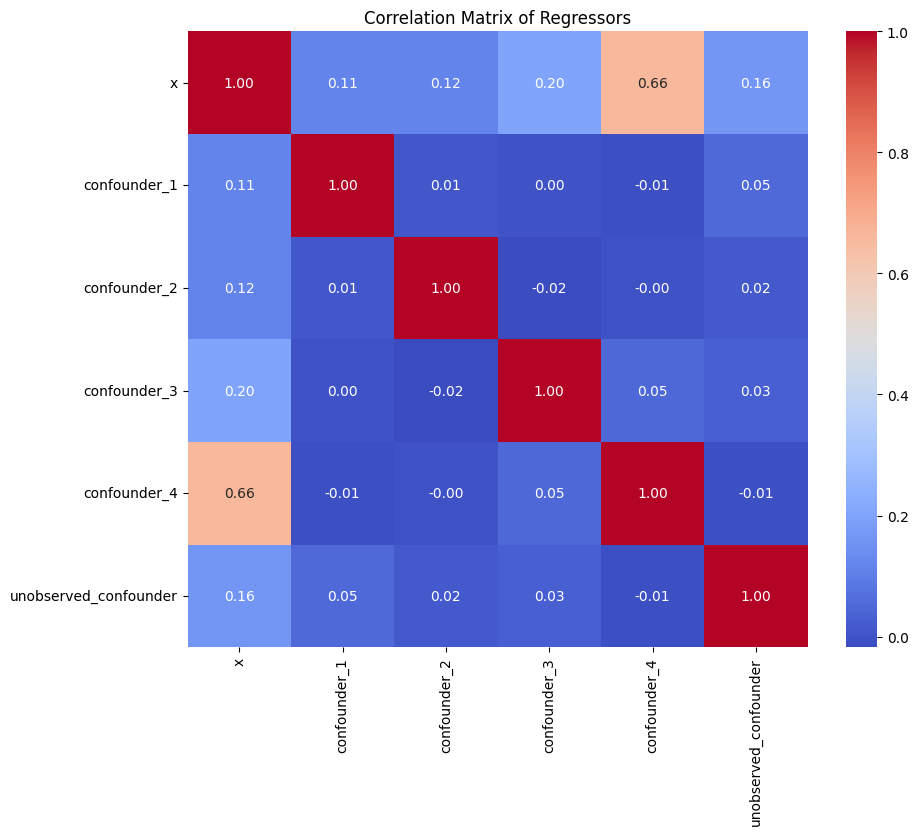

In [ ]:
# prompt: correlation matrix between the regressors

# Correlation matrix between regressors
regressors = ['x', 'confounder_1', 'confounder_2', 'confounder_3', 'confounder_4',  'unobserved_confounder']
correlation_matrix = df[regressors].corr()

# Optionally, you can visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Regressors')
plt.show()

## 1. Directed Acyclic Graph (DAG)

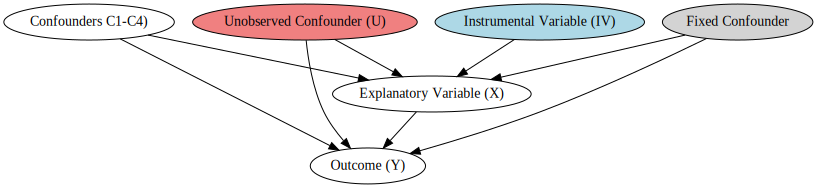

In [ ]:
# Create a directed graph
dag = gr.Digraph("causal_dag", format="png")

# Define nodes
dag.node("X", "Explanatory Variable (X)")
dag.node("C1-C4", "Confounders C1-C4)")
dag.node("U", "Unobserved Confounder (U)", style="filled", fillcolor="lightcoral")
dag.node("FE", "Fixed Confounder", style="filled", fillcolor="lightgrey")
dag.node("IV", "Instrumental Variable (IV)", style="filled", fillcolor="lightblue")
dag.node("Y", "Outcome (Y)")

# Define edges
dag.edge("IV", "X")         # IV affects U (instrument relevance)
dag.edge("U", "Y")          # U affects Y (confounding path)
dag.edge("U", "X")          # U affects X (confounding path)
dag.edge("FE", "Y")         # Fixed effect affects Y
dag.edge("FE", "X")         # Fixed effect affects X
dag.edge("X", "Y")          # Explanatory variable affects Y
dag.edge("C1-C4", "Y")      # Confounders C1-C4affects Y
dag.edge("C1-C4", "X")      # Confounders C1-C4 affects X


# Render the DAG
dag

## 2. Simple Linear Regression

The first step is to run a simple linear regression.

$$
\begin{aligned}
& Y = \beta_0 + \beta_1 X + \epsilon
\end{aligned}
$$

In [ ]:
# Define the model formula without controls
model_formula_no_controls = 'y ~ x'

# Fit the model using ordinary least squares (OLS)
# Use clustered standard errors
slr = smf.ols(formula=model_formula_no_controls, data=df).fit(cov_type='cluster', cov_kwds={'groups': df['id']})

# Store the model summary in a variable
slr_summary = slr.summary


# Print the model summary
print(slr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 8.651e+04
Date:                Tue, 12 Nov 2024   Prob (F-statistic):          1.89e-147
Time:                        22:01:55   Log-Likelihood:                -1917.0
No. Observations:                1000   AIC:                             3838.
Df Residuals:                     998   BIC:                             3848.
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0318      0.054      0.593      0.5

## 3. Multiple Linear Regression

Now we can include a vector of observed controls. A strong assumption with respect to the function form is made: All the effects of the confounders have no interactions and are linear.

$$
\begin{aligned}
& Y = \beta_0 + \beta_1 X + Z'\lambda + \epsilon
\end{aligned}
$$

In [ ]:
# Define the model formula without controls
model_formula_no_controls = 'y ~ x+confounder_1+confounder_2+confounder_3+confounder_4'

# Fit the model using ordinary least squares (OLS)
# Use clustered standard errors
mlr = smf.ols(formula=model_formula_no_controls, data=df).fit(cov_type='cluster', cov_kwds={'groups': df['id']})

# Store the model summary in a variable
mlr_summary = mlr.summary


# Print the model summary
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.659e+04
Date:                Tue, 12 Nov 2024   Prob (F-statistic):          5.17e-143
Time:                        22:01:55   Log-Likelihood:                -1910.2
No. Observations:                1000   AIC:                             3832.
Df Residuals:                     994   BIC:                             3862.
Df Model:                           5                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0604      0.055      1.094   

In [ ]:
# Create a DataFrame to store the coefficients and confidence intervals
summary_data = {
    'Model': ['Without Controls', 'With Controls'],
    'coef': [slr.params['x'], mlr.params['x']],
    '2.5 %': [slr.conf_int().loc['x', 0], mlr.conf_int().loc['x', 0]],
    '97.5 %': [slr.conf_int().loc['x', 1], mlr.conf_int().loc['x', 1]]
}
summary_df = pd.DataFrame(summary_data).set_index('Model')

# Print the summary
print(summary_df[['coef', '2.5 %', '97.5 %']])

                      coef     2.5 %    97.5 %
Model                                         
Without Controls  1.967980  1.954867  1.981094
With Controls     1.944989  1.926638  1.963340


## 4. Double Machine Learning

The next step is to relax the assumptions on the functional form of the nuisance function.

- **DML** = Frisch-Waugh-Lovell Theorem **_on Steroids_**

- Imagine now a more complex model where $g_0() $ and $ m_0() $ are not necessarily known or linear functions.
  
  $$
  Y = \beta_1 X + g_0(Z) + \epsilon
  $$
  
  $$
  X = m_0(Z) + \xi
  $$

- We can again residualize $ Y $ and $ X $:
  
 $$
  \tilde{Y} = \beta_1 \tilde{X} + \zeta
  $$

- But this time, we use Machine Learning to estimate $ g_0() $ and $ m_0() $, which are functions of the vector of controls $ Z $.


In [ ]:
# Create a DoubleMLClusterData object to prepare the data for Double Machine Learning.
# This object specifies the outcome variable ('y'), treatment variable ('x'),
# clustering variable ('id'), and confounders ('x_cols').
obj_dml_data_from_df = DoubleMLClusterData(df, 'y', 'x', ['id'], x_cols=['confounder_1', 'confounder_2', 'confounder_3', 'confounder_4'])

# Print the DoubleMLClusterData object to display its properties and data information.
print(obj_dml_data_from_df)

================== DoubleMLClusterData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['x']
Cluster variable(s): ['id']
Covariates: ['confounder_1', 'confounder_2', 'confounder_3', 'confounder_4']
Instrument variable(s): None
No. Observations: 1000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 11 entries, id to y
dtypes: float64(9), int64(2)
memory usage: 86.1 KB



In [ ]:
# Estimate the ATE using Decision Trees as the machine learning model


# Define a Decision Tree Regressor with simple, fixed parameters
tree_model = DecisionTreeRegressor(
    max_depth=10,  # Limit the depth of the tree to prevent overfitting
    min_samples_split=50,  # Minimum samples required to split a node
    min_samples_leaf=20  # Minimum samples required to be at a leaf node
)

# Initialize DoubleMLPLR with the Decision Tree model for both outcome and treatment models
dml_tree= dml.DoubleMLPLR(
    obj_dml_data_from_df,   # This is the DoubleML data object
    ml_l=tree_model,  # Decision Tree model for outcome regression
    ml_m=tree_model,  # Decision Tree model for treatment regression
    n_folds=3         # Use 3-fold cross-fitting (simpler for students to understand)
)

# Fit the DoubleMLPLR model
dml_tree.fit(store_predictions=True)

# Store the model summary in a variable
tree_summary = dml_tree.summary  # Assigns the model summary to the 'forest_summary' variable


# Display the summary of the estimated Average Treatment Effect (ATE)
print(dml_tree.summary)

       coef   std err           t  P>|t|     2.5 %    97.5 %
x  1.935144  0.015377  125.843043    0.0  1.905005  1.965283


In [ ]:
# Estimate the ATE using Random Forest as the machine learning model

# randomForest: Initialize a Random Forest Regressor for outcome regression
randomForest = RandomForestRegressor(
    n_estimators=500,  # Number of trees in the forest
    max_depth=7,  # Maximum depth of each tree
    max_features=3,  # Number of features to consider when looking for the best split
    min_samples_leaf=3)  # Minimum number of samples required to be at a leaf node

# Initialize the DoubleMLPLR model with Random Forest learners
dml_plr_forest = dml.DoubleMLPLR(obj_dml_data_from_df,  # Uses the 'data_dml_base' DoubleMLData object
                                 ml_l=randomForest,  # Specifies the Random Forest Regressor for outcome regression
                                 ml_m=randomForest,  # Specifies the Random Forest Classifier for treatment regression
                                 n_folds=3)  # Sets the number of folds for cross-fitting to 3

# Fit the DoubleMLPLR model to the data
dml_plr_forest.fit(store_predictions=True)  # Fits the model and stores predictions

# Store the model summary in a variable
forest_summary = dml_plr_forest.summary  # Assigns the model summary to the 'forest_summary' variable

# Print the model summary
print(forest_summary)  # Displays the estimated ATE and other model information

       coef   std err           t  P>|t|     2.5 %    97.5 %
x  1.938364  0.009797  197.845371    0.0  1.919162  1.957567


In [ ]:
# Estimate the ATE using Boosted Trees (XGBoost) as the machine learning model

# boost: Initialize an XGBoost Regressor for outcome regression
boost = XGBRegressor(n_jobs=1,  # Number of parallel threads used to run XGBoost
                     objective="reg:squarederror",  # Objective function for regression (squared error)
                     eta=0.1,  # Learning rate
                     n_estimators=35)  # Number of boosting rounds (trees)


# Set the random seed for reproducibility
np.random.seed(123)  # Ensures consistent results

# Initialize the DoubleMLPLR model with XGBoost learners
dml_plr_boost = dml.DoubleMLPLR(obj_dml_data_from_df,  # Uses the 'data_dml_base' DoubleMLData object
                                ml_l=boost,  # Specifies the XGBoost Regressor for outcome regression
                                ml_m=boost,  # Specifies the XGBoost Classifier for treatment regression
                                n_folds=3)  # Sets the number of folds for cross-fitting to 3

# Fit the DoubleMLPLR model to the data
dml_plr_boost.fit(store_predictions=True)  # Fits the model and stores predictions

# Store the model summary in a variable
boost_summary = dml_plr_boost.summary  # Assigns the model summary to the 'boost_summary' variable

# Print the model summary
print(boost_summary)  # Displays the estimated ATE and other model information

      coef   std err           t  P>|t|     2.5 %    97.5 %
x  1.89006  0.017306  109.214101    0.0  1.856141  1.923979


In [ ]:
# Concatenate the summaries and update the index
plr_summary = pd.concat([summary_df, forest_summary, tree_summary, boost_summary])
plr_summary.index = ['slr', 'mlr', 'forest', 'tree', 'xgb']

# Print the updated summary
print(plr_summary[['coef', '2.5 %', '97.5 %']])

            coef     2.5 %    97.5 %
slr     1.967980  1.954867  1.981094
mlr     1.944989  1.926638  1.963340
forest  1.938364  1.919162  1.957567
tree    1.935144  1.905005  1.965283
xgb     1.890060  1.856141  1.923979


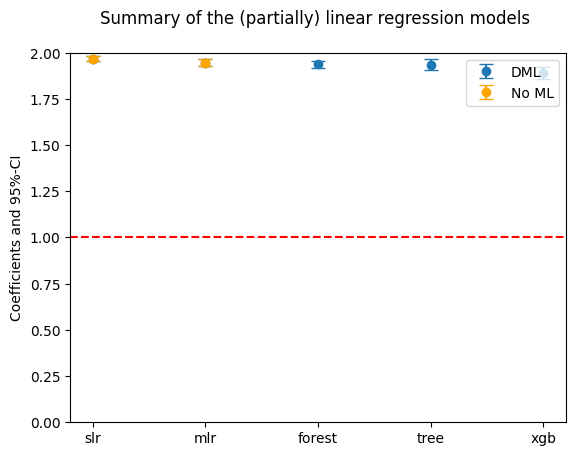

In [ ]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
# Plot error bars for all models
plt.errorbar(plr_summary.index, plr_summary['coef'], yerr=errors, fmt='o', capsize=5)

# Plot the first two coefficients in orange
plt.errorbar(plr_summary.index[:2], plr_summary['coef'][:2], yerr=errors[:, :2], fmt='o', color='orange', capsize=5)

plt.ylim([0, 2])

plt.legend(['DML', 'No ML'], loc='upper right')  # Place legend in upper left corner

#add horizontal bar at 1
plt.axhline(y=1, color='r', linestyle='--')

plt.title('Summary of the (partially) linear regression models \n')
_ =  plt.ylabel('Coefficients and 95%-CI')

## 5. Fixed Effects

In the initial DAG, we suggested that we had unobserved idiosyncratic confounders fixed over time. One way to control for this is to use the first difference estimator. First difference estimator seems to be the most adequate one based on research compared to demeaning or including fixed effects (c.f Double Machine Learning for Static Panel Models with Fixed Effects, https://arxiv.org/abs/2312.08174)

In [ ]:
# Identify columns to compute first differences (excluding 'unobserved_confounder' and 'unobserved_fe')
columns_to_diff = df.columns.difference(['id', 'year', 'unobserved_confounder', 'unobserved_fe'])

# Sort the DataFrame by 'id' and 'year' to ensure correct ordering
df_sorted = df.sort_values(['id', 'year']).reset_index(drop=True)

# Compute the first difference within each individual group
df_diff = df_sorted.groupby('id')[columns_to_diff].diff().dropna()  # Drop NaN for the first observation in each group

# Retain 'id', 'year', 'unobserved_confounder', and 'unobserved_fe' as they are
df_diff[['id', 'year', 'unobserved_confounder', 'unobserved_fe']] = df_sorted[['id', 'year', 'unobserved_confounder', 'unobserved_fe']].iloc[1:].reset_index(drop=True)

# **Check for and handle NaN values in the 'id' column**
if df_diff['id'].isnull().any():
    # Handle NaN values, for example, by filling with a specific value or dropping rows
    # df_diff['id'].fillna(value, inplace=True)  # Replace NaN with 'value'
    df_diff.dropna(subset=['id'], inplace=True)  # Drop rows with NaN in 'id'
    print("NaN values in 'id' column handled.")
else:
    print("No NaN values found in 'id' column.")

# Display the first-differenced DataFrame
df_diff.head()

NaN values in 'id' column handled.


,confounder_1,confounder_2,confounder_3,confounder_4,iv,x,y,id,year,unobserved_confounder,unobserved_fe
1,2.804123,0.100757,-1.107545,-1.358877,-1.662411,-4.734561,-6.550916,1.0,3.0,0.046562,1.507361
2,-1.659763,-0.870209,1.131714,-0.819647,2.623683,-3.851296,-11.568295,1.0,4.0,-1.679829,1.507361
3,0.410665,1.840590,3.347432,2.116812,-1.745359,19.049581,39.812453,1.0,5.0,1.395892,1.507361
4,1.441201,-0.373966,-2.564244,0.062819,-0.407937,-4.998548,-9.536050,1.0,6.0,-0.844971,1.507361
5,-0.789117,-2.358042,0.123615,-1.260262,1.607752,-12.365613,-24.931557,1.0,7.0,0.814007,1.507361


In [ ]:
obj_dml_diff = DoubleMLClusterData(df_diff, 'y', 'x', ['id'], x_cols=['confounder_1',	'confounder_2',	'confounder_3',	'confounder_4'])
print(obj_dml_diff)

================== DoubleMLClusterData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['x']
Cluster variable(s): ['id']
Covariates: ['confounder_1', 'confounder_2', 'confounder_3', 'confounder_4']
Instrument variable(s): None
No. Observations: 899

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
Index: 899 entries, 1 to 998
Columns: 11 entries, confounder_1 to unobserved_fe
dtypes: float64(11)
memory usage: 84.3 KB



In [ ]:
# Estimate the ATE using Random Forest as the machine learning model

# randomForest: Initialize a Random Forest Regressor for outcome regression
randomForest = RandomForestRegressor(
    n_estimators=500,  # Number of trees in the forest
    max_depth=7,  # Maximum depth of each tree
    max_features=3,  # Number of features to consider when looking for the best split
    min_samples_leaf=3)  # Minimum number of samples required to be at a leaf node

# Initialize the DoubleMLPLR model with Random Forest learners
dml_plr_forest = dml.DoubleMLPLR(obj_dml_diff,  # Uses the 'data_dml_base' DoubleMLData object
                                 ml_l=randomForest,  # Specifies the Random Forest Regressor for outcome regression
                                 ml_m=randomForest,  # Specifies the Random Forest Classifier for treatment regression
                                 n_folds=3)  # Sets the number of folds for cross-fitting to 3

# Fit the DoubleMLPLR model to the data
dml_plr_forest.fit(store_predictions=True)  # Fits the model and stores predictions

# Store the model summary in a variable
forest_diff_summary = dml_plr_forest.summary  # Assigns the model summary to the 'forest_summary' variable

# Print the model summary
print(forest_diff_summary)  # Displays the estimated ATE and other model information

       coef   std err          t  P>|t|     2.5 %   97.5 %
x  1.761113  0.025346  69.483022    0.0  1.711435  1.81079


In [ ]:
# Estimate the ATE using Decision Trees as the machine learning model


# Define a Decision Tree Regressor with simple, fixed parameters
tree_model = DecisionTreeRegressor(
    max_depth=10,  # Limit the depth of the tree to prevent overfitting
    min_samples_split=50,  # Minimum samples required to split a node
    min_samples_leaf=20  # Minimum samples required to be at a leaf node
)

# Initialize DoubleMLPLR with the Decision Tree model for both outcome and treatment models
dml_tree= dml.DoubleMLPLR(
    obj_dml_diff,   # This is the DoubleML data object
    ml_l=tree_model,  # Decision Tree model for outcome regression
    ml_m=tree_model,  # Decision Tree model for treatment regression
    n_folds=3         # Use 3-fold cross-fitting (simpler for students to understand)
)

# Fit the DoubleMLPLR model
dml_tree.fit(store_predictions=True)

# Store the model summary in a variable
tree_diff_summary = dml_tree.summary  # Assigns the model summary to the 'forest_summary' variable


# Display the summary of the estimated Average Treatment Effect (ATE)
print(dml_tree.summary)

       coef   std err          t  P>|t|     2.5 %    97.5 %
x  1.649198  0.031492  52.368946    0.0  1.587475  1.710921


In [ ]:
# Estimate the ATE using Boosted Trees (XGBoost) as the machine learning model

# boost: Initialize an XGBoost Regressor for outcome regression
boost = XGBRegressor(
    n_jobs=1,  # Number of parallel threads used to run XGBoost
    objective="reg:squarederror",  # Objective function for regression (squared error)
    eta=0.1,  # Learning rate
    n_estimators=50,  # Increased number of boosting rounds (trees)
    max_depth=7,  # Limit tree depth to prevent overfitting
    subsample=0.8,  # Use 80% of data for each tree to add robustness
    colsample_bytree=0.8  # Use 80% of features for each tree to reduce complexity
)


# Set the random seed for reproducibility
np.random.seed(123)  # Ensures consistent results

# Initialize the DoubleMLPLR model with XGBoost learners
dml_plr_boost = dml.DoubleMLPLR( obj_dml_diff,  # Uses the 'data_dml_base' DoubleMLData object
                                ml_l=boost,  # Specifies the XGBoost Regressor for outcome regression
                                ml_m=boost,  # Specifies the XGBoost Classifier for treatment regression
                                n_folds=3)  # Sets the number of folds for cross-fitting to 3

# Fit the DoubleMLPLR model to the data
dml_plr_boost.fit(store_predictions=True)  # Fits the model and stores predictions

# Store the model summary in a variable
boost_diff_summary = dml_plr_boost.summary  # Assigns the model summary to the 'boost_summary' variable

# Print the model summary
print(boost_diff_summary)  # Displays the estimated ATE and other model information

       coef   std err          t  P>|t|     2.5 %    97.5 %
x  1.733904  0.027632  62.749684    0.0  1.679746  1.788062


In [ ]:
# Concatenate the summaries and update the index
plr_summary = pd.concat([summary_df, forest_summary, tree_summary, boost_summary, forest_diff_summary, tree_diff_summary, boost_diff_summary])
plr_summary.index = ['slr', 'mlr', 'forest', 'tree', 'xgb', 'forest (fd)', 'tree (fd)', 'xgb (fd)']

# Print the updated summary
print(plr_summary[['coef', '2.5 %', '97.5 %']])

                 coef     2.5 %    97.5 %
slr          1.967980  1.954867  1.981094
mlr          1.944989  1.926638  1.963340
forest       1.938364  1.919162  1.957567
tree         1.935144  1.905005  1.965283
xgb          1.890060  1.856141  1.923979
forest (fd)  1.761113  1.711435  1.810790
tree (fd)    1.649198  1.587475  1.710921
xgb (fd)     1.733904  1.679746  1.788062


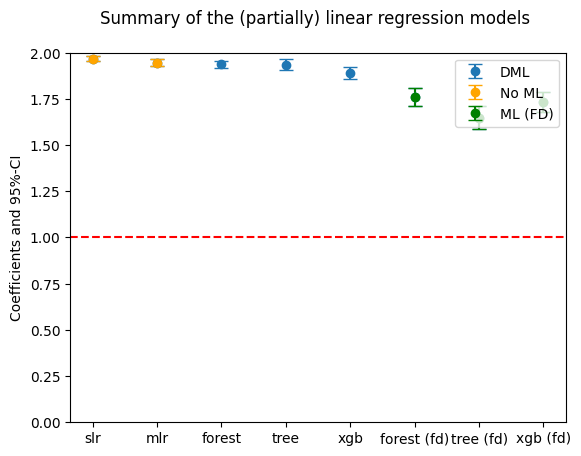

In [ ]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
# Plot error bars for all models
plt.errorbar(plr_summary.index, plr_summary['coef'], yerr=errors, fmt='o', capsize=5)

# Plot the first two coefficients in orange
plt.errorbar(plr_summary.index[:2], plr_summary['coef'][:2], yerr=errors[:, :2], fmt='o', color='orange', capsize=5)

plt.errorbar(plr_summary.index[5:], plr_summary['coef'][5:], yerr=errors[:, 5:], fmt='o', color='green', capsize=5)


plt.ylim([0, 2])

plt.legend(['DML', 'No ML', 'ML (FD)'], loc='upper right')  # Place legend in upper left corner

#add horizontal bar at 1
plt.axhline(y=1, color='r', linestyle='--')

plt.title('Summary of the (partially) linear regression models \n')
_ =  plt.ylabel('Coefficients and 95%-CI')

## 6.  Instrumental variable
We are not there yet. Our current estimation of $\beta_1$ is around 1.7 while the true value is 1.

Luckily we know the DGP and hence we can use an Instrumental Variable to do the estimation and address the remaining issue of time varying idiosyncratic confounders.

In [ ]:
obj_dml_diff_iv = DoubleMLClusterData(df_diff, 'y', 'x', ['id'], x_cols=['confounder_1',	'confounder_2',	'confounder_3',	'confounder_4'], z_cols='iv')
print(obj_dml_diff_iv)

================== DoubleMLClusterData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['x']
Cluster variable(s): ['id']
Covariates: ['confounder_1', 'confounder_2', 'confounder_3', 'confounder_4']
Instrument variable(s): ['iv']
No. Observations: 899

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
Index: 899 entries, 1 to 998
Columns: 11 entries, confounder_1 to unobserved_fe
dtypes: float64(11)
memory usage: 84.3 KB



In [ ]:
# Estimate the ATE using Random Forest as the machine learning model

# randomForest: Initialize a Random Forest Regressor for outcome regression
randomForest = RandomForestRegressor(
    n_estimators=500,  # Number of trees in the forest
    max_depth=7,  # Maximum depth of each tree
    max_features=3,  # Number of features to consider when looking for the best split
    min_samples_leaf=3)  # Minimum number of samples required to be at a leaf node

# Initialize the DoubleMLPLR model with Random Forest learners
dml_plr_forest = dml.DoubleMLPLIV(obj_dml_diff_iv,  # Uses the 'data_dml_base' DoubleMLData object
                                 ml_l=randomForest,  # Specifies the Random Forest Regressor for outcome regression
                                 ml_m=randomForest,  # Specifies the Random Forest Classifier for treatment regression
                                 ml_r=randomForest,  # Specifies the Random Forest Classifier for iv regression
                                 n_folds=3)  # Sets the number of folds for cross-fitting to 3

# Fit the DoubleMLPLR model to the data
dml_plr_forest.fit(store_predictions=True)  # Fits the model and stores predictions

# Store the model summary in a variable
forest_diff_iv_summary = dml_plr_forest.summary  # Assigns the model summary to the 'forest_summary' variable

# Print the model summary
print(forest_diff_iv_summary)  # Displays the estimated ATE and other model information

       coef   std err         t         P>|t|     2.5 %    97.5 %
x  1.010159  0.107709  9.378616  6.684431e-21  0.799054  1.221265


In [ ]:
# Estimate the ATE using Decision Trees as the machine learning model


# Define a Decision Tree Regressor with simple, fixed parameters
tree_model = DecisionTreeRegressor(
    max_depth=10,  # Limit the depth of the tree to prevent overfitting
    min_samples_split=50,  # Minimum samples required to split a node
    min_samples_leaf=20  # Minimum samples required to be at a leaf node
)

# Initialize DoubleMLPLR with the Decision Tree model for both outcome and treatment models
dml_tree= dml.DoubleMLPLIV(
    obj_dml_diff_iv,   # This is the DoubleML data object
    ml_l=tree_model,  # Decision Tree model for outcome regression
    ml_m=tree_model,  # Decision Tree model for treatment regression
    ml_r=tree_model,  # Specifies the Random Forest Classifier for iv regression
    n_folds=3         # Use 3-fold cross-fitting (simpler for students to understand)
)

# Fit the DoubleMLPLR model
dml_tree.fit(store_predictions=True)

# Store the model summary in a variable
tree_diff_iv_summary = dml_tree.summary  # Assigns the model summary to the 'forest_summary' variable


# Display the summary of the estimated Average Treatment Effect (ATE)
print(dml_tree.summary)

       coef   std err        t         P>|t|     2.5 %    97.5 %
x  0.895574  0.136629  6.55478  5.572394e-11  0.627785  1.163362


In [ ]:
# Estimate the ATE using Boosted Trees (XGBoost) as the machine learning model

# boost: Initialize an XGBoost Regressor for outcome regression
boost = XGBRegressor(
    n_jobs=1,  # Number of parallel threads used to run XGBoost
    objective="reg:squarederror",  # Objective function for regression (squared error)
    eta=0.1,  # Learning rate
    n_estimators=50,  # Increased number of boosting rounds (trees)
    max_depth=7,  # Limit tree depth to prevent overfitting
    subsample=0.8,  # Use 80% of data for each tree to add robustness
    colsample_bytree=0.8  # Use 80% of features for each tree to reduce complexity
)


# Set the random seed for reproducibility
np.random.seed(123)  # Ensures consistent results

# Initialize the DoubleMLPLR model with XGBoost learners
dml_plr_boost = dml.DoubleMLPLIV( obj_dml_diff_iv,  # Uses the 'data_dml_base' DoubleMLData object
                                ml_l=boost,  # Specifies the XGBoost Regressor for outcome regression
                                ml_m=boost,  # Specifies the XGBoost Classifier for treatment regression
                                ml_r=boost,  # Specifies the Random Forest Classifier for iv regression
                                n_folds=3)  # Sets the number of folds for cross-fitting to 3

# Fit the DoubleMLPLR model to the data
dml_plr_boost.fit(store_predictions=True)  # Fits the model and stores predictions

# Store the model summary in a variable
boost_diff_iv_summary = dml_plr_boost.summary  # Assigns the model summary to the 'boost_summary' variable

# Print the model summary
print(boost_diff_iv_summary)  # Displays the estimated ATE and other model information

       coef   std err         t         P>|t|     2.5 %    97.5 %
x  1.011021  0.119759  8.442135  3.115940e-17  0.776298  1.245745


In [ ]:
# Concatenate the summaries and update the index
plr_summary = pd.concat([summary_df, forest_summary, tree_summary, boost_summary, forest_diff_summary, tree_diff_summary, boost_diff_summary, forest_diff_iv_summary, tree_diff_iv_summary, boost_diff_iv_summary])
plr_summary.index = ['slr', 'mlr', 'forest', 'tree', 'xgb', 'forest (fd)', 'tree (fd)', 'xgb (fd)','forest (fd+iv)', 'tree (fd+iv)', 'xgb (fd+iv)']

# Print the updated summary
print(plr_summary[['coef', '2.5 %', '97.5 %']])

                    coef     2.5 %    97.5 %
slr             1.967980  1.954867  1.981094
mlr             1.944989  1.926638  1.963340
forest          1.938364  1.919162  1.957567
tree            1.935144  1.905005  1.965283
xgb             1.890060  1.856141  1.923979
forest (fd)     1.761113  1.711435  1.810790
tree (fd)       1.649198  1.587475  1.710921
xgb (fd)        1.733904  1.679746  1.788062
forest (fd+iv)  1.010159  0.799054  1.221265
tree (fd+iv)    0.895574  0.627785  1.163362
xgb (fd+iv)     1.011021  0.776298  1.245745


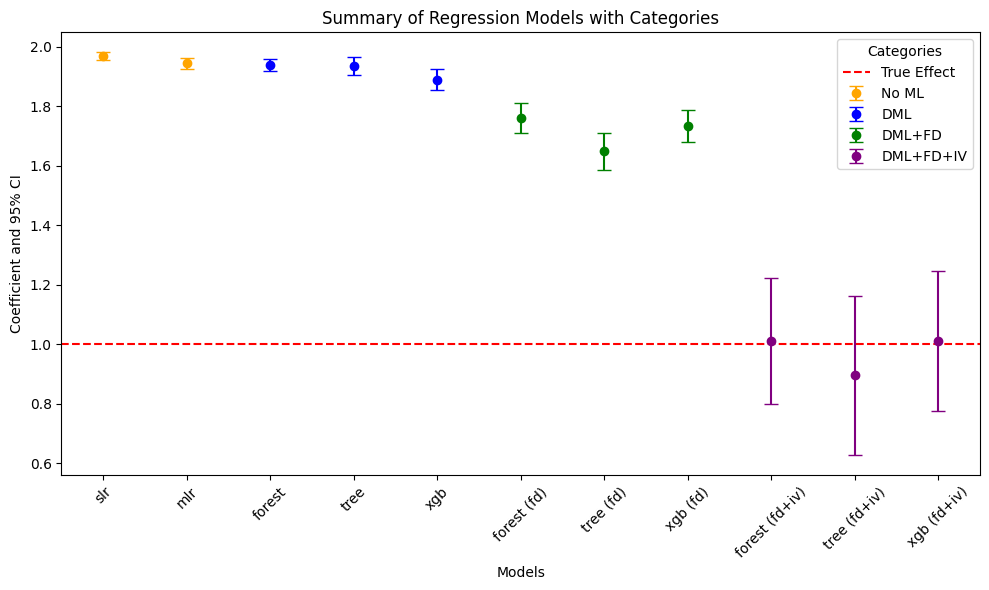

In [ ]:
# Assign categories based on the index naming
plr_summary['category'] = [
    'No ML', 'No ML', 'DML', 'DML', 'DML',
    'DML+FD', 'DML+FD', 'DML+FD',
    'DML+FD+IV', 'DML+FD+IV', 'DML+FD+IV'
]

# Plotting
plt.figure(figsize=(10, 6))

# Define colors for each category
category_colors = {
    'No ML': 'orange',
    'DML': 'blue',
    'DML+FD': 'green',
    'DML+FD+IV': 'purple'
}

# Plot each category with different colors
for category, color in category_colors.items():
    category_data = plr_summary[plr_summary['category'] == category]
    plt.errorbar(
        category_data.index, category_data['coef'],
        yerr=[category_data['coef'] - category_data['2.5 %'], category_data['97.5 %'] - category_data['coef']],
        fmt='o', color=color, label=category, capsize=5
    )

# Add reference line at coefficient 1.0
plt.axhline(y=1.0, color='red', linestyle='--', label='True Effect')

# Formatting the plot
plt.title('Summary of Regression Models with Categories')
plt.xlabel('Models')
plt.ylabel('Coefficient and 95% CI')
plt.xticks(rotation=45)
plt.legend(title='Categories')
plt.tight_layout()

# Show plot
plt.show()